
### Step 1: Data Collection -- Where can we find the data?

Short answer [Top Tracks of 2025 Global on Spotify](https://open.spotify.com/playlist/37i9dQZF1DX18jTM2l2fJY) which contains a list of the top 50 songs with most streams on spotify last year.




In [9]:
import pandas as pd
import json
import time
from itertools import islice
from youtube_comment_downloader import YoutubeCommentDownloader, SORT_BY_POPULAR

In [16]:
# Load the CSV
df_youtube_urls = pd.read_csv('youtube_urls.csv')

# Config
MAX_COMMENTS = 450000
OUTPUT_FILE = 'youtube_comments_3.json'

downloader = YoutubeCommentDownloader()
all_comments = []

urls = df_youtube_urls['YouTube URL'].dropna().tolist()
num_videos = len(urls)
print(f"Scraping as many comments as possible per video across {num_videos} videos...")
print(f"Target total cap: {MAX_COMMENTS} comments\n")

for idx, row in df_youtube_urls.iterrows():
    # Stop earlier if we already hit the global maximum
    if len(all_comments) >= MAX_COMMENTS:
        print(f"Reached the maximum limit of {MAX_COMMENTS} overall comments. Stopping.")
        break

    url = row.get('YouTube URL')
    title = row.get('Song Title', 'Unknown')
    artists = row.get('Artists', 'Unknown')

    if pd.isna(url) or not url.strip():
        print(f"  Skipping row {idx} — no URL")
        continue

    print(f"[{idx + 1}/{len(df_youtube_urls)}] {title} — {artists}")
    print(f"  URL: {url}")

    try:
        comments = downloader.get_comments_from_url(url, sort_by=SORT_BY_POPULAR)
        count = 0
        
        # Iterate over all available comments without slicing
        for comment in comments:
            comment['song_title'] = title
            comment['artists'] = artists
            comment['youtube_url'] = url
            all_comments.append(comment)
            count += 1
            
            # Stop mid-video if we hit the global limit
            if len(all_comments) >= MAX_COMMENTS:
                break

        print(f"  ✓ Collected {count} comments")
    except Exception as e:
        print(f"  ✗ Error: {e}")

    # Brief pause to avoid rate limiting
    time.sleep(1)

print(f"\nTotal comments collected: {len(all_comments)}")

# Save to JSON
with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(all_comments, f, ensure_ascii=False, indent=2)

print(f"Saved to {OUTPUT_FILE}\n")

Scraping as many comments as possible per video across 15 videos...
Target total cap: 450000 comments

[1/15] Ordinary — Alex Warren
  URL: https://www.youtube.com/watch?v=u2ah9tWTkmk
  ✓ Collected 11346 comments
[2/15] DtMF — Bad Bunny
  URL: https://www.youtube.com/watch?v=v9T_MGfzq7I
  ✓ Collected 3609 comments
[3/15] Golden — HUNTR/X
  URL: https://www.youtube.com/watch?v=yebNIHKAC4A
  ✓ Collected 9367 comments
[4/15] BAILE INoLVIDABLE — Bad Bunny
  URL: https://www.youtube.com/watch?v=a1Femq4NPxs
  ✓ Collected 8824 comments
[5/15] The Fate of Ophelia — Taylor Swift
  URL: https://www.youtube.com/watch?v=ko70cExuzZM
  ✓ Collected 11818 comments
[6/15] NUEVAYoL — Bad Bunny
  URL: https://www.youtube.com/watch?v=KU5V5WZVcVE
  ✓ Collected 4173 comments
[7/15] La Plena — W Sound (Beéle Westcol Ovy On The Drums)
  URL: https://www.youtube.com/watch?v=F1_aOX0acbY
  ✓ Collected 4738 comments
[8/15] EoO — Bad Bunny
  URL: https://www.youtube.com/watch?v=myDIeOjqQos
  ✓ Collected 2158 comme

In [18]:
import pandas as pd
import json

# 1. Load the two JSON datasets
with open('comments_merged.json', 'r', encoding='utf-8') as f:
    data1 = json.load(f)

with open('youtube_comments_3.json', 'r', encoding='utf-8') as f:
    data2 = json.load(f)

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

df_merged = pd.concat([df1, df2], ignore_index=True)
df_merged = df_merged.drop_duplicates(subset=['cid'], keep='first')

merged_data = df_merged.to_dict(orient='records')

with open('comments_merged.json', 'w', encoding='utf-8') as f:
    json.dump(merged_data, f, ensure_ascii=False, indent=2)

print(f"Merged {len(df1)} and {len(df2)} comments into comments_meged.json")
print(f"Total unique comments after removing duplicates: {len(df_merged)}")


Merged 84485 and 81000 comments into comments_meged.json
Total unique comments after removing duplicates: 84816


In [19]:
import json
# Load comments from JSON
with open('comments_merged.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df_comments = pd.DataFrame(data)

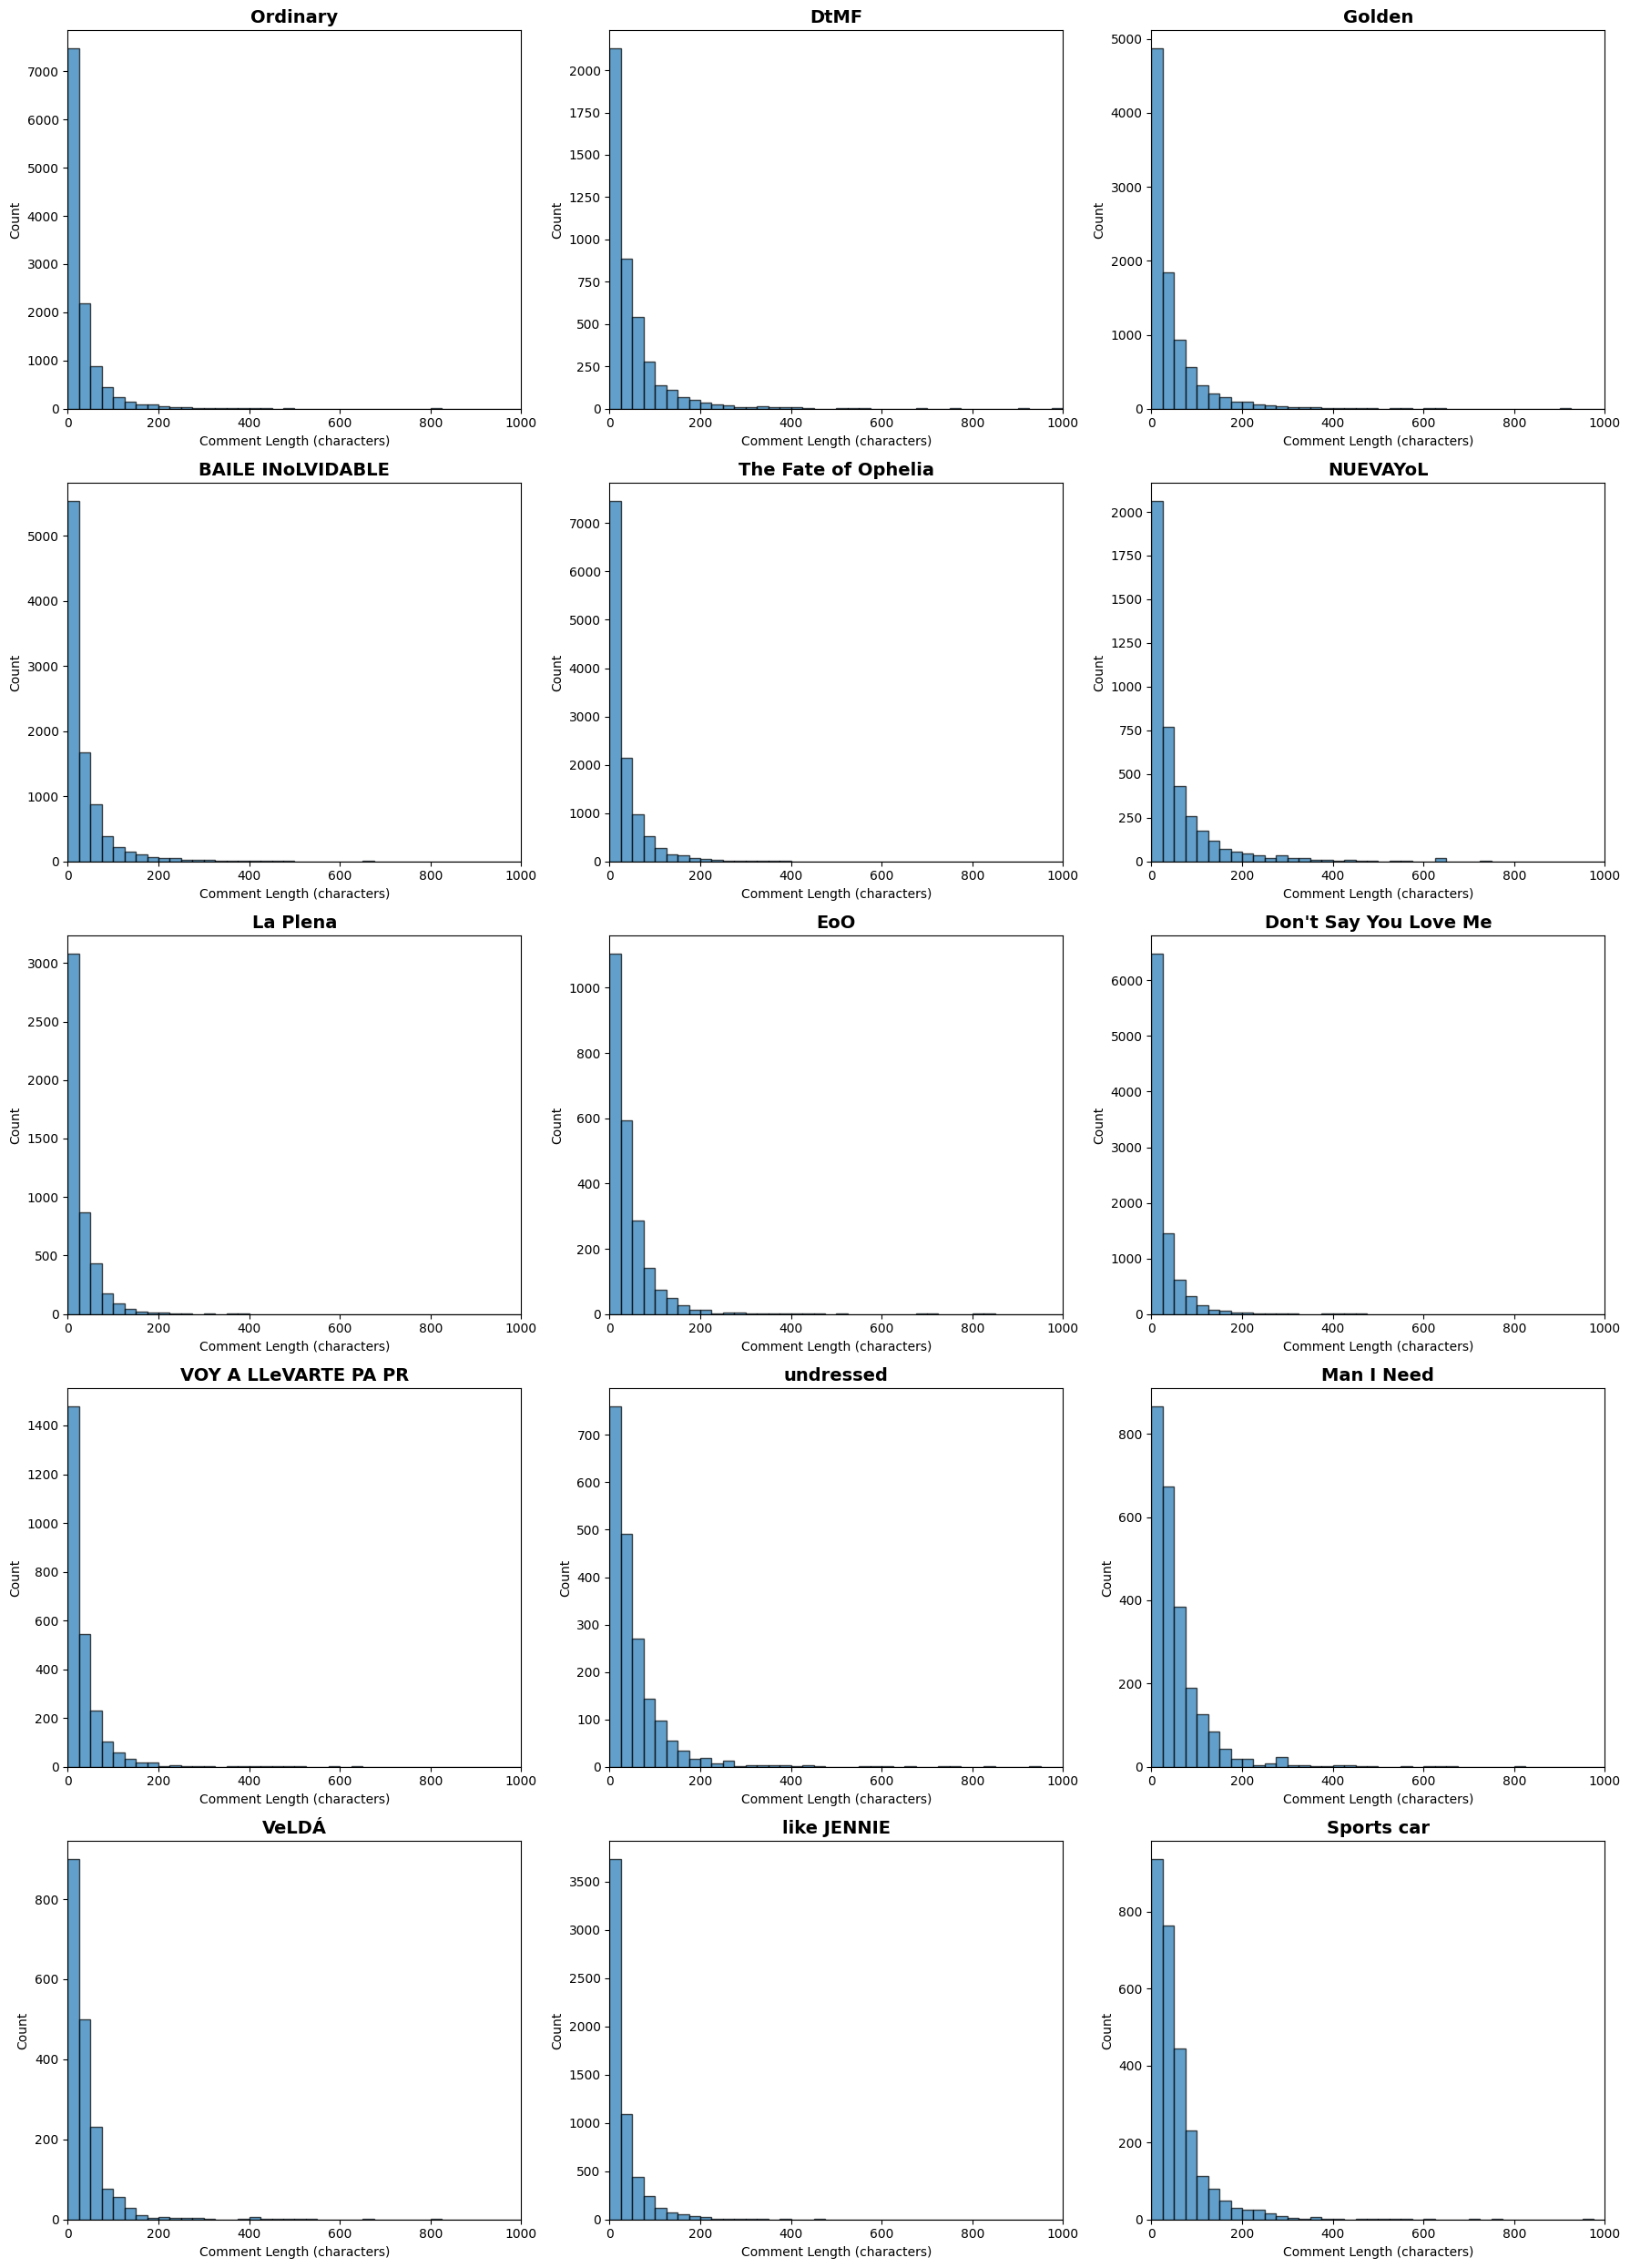

In [20]:
import matplotlib.pyplot as plt
import numpy as np

df_comments['text_length'] = df_comments['text'].astype(str).apply(len)

songs = df_comments['song_title'].unique()
max_len = df_comments['text_length'].max()
bins = np.arange(0, max_len + 25, 25)

ncols = 3
nrows = int(np.ceil(len(songs) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten()

for ax, song in zip(axes, songs):
    song_data = df_comments[df_comments['song_title'] == song]['text_length']
    ax.hist(song_data, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title(f'{song}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Comment Length (characters)')
    ax.set_ylabel('Count')
    ax.set_xlim(0, min(max_len, 1000))

# Hide any leftover empty axes
for ax in axes[len(songs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [21]:
with open('top_comments_by_song.md', 'w', encoding='utf-8') as f:
    f.write('# Top 25 Longest Comments by Song\n\n')

    print(f"Total comments loaded: {len(df_comments)}")
    print(f"Unique songs: {df_comments['song_title'].nunique()}")
    print()

    for song in df_comments['song_title'].unique():
        song_df = df_comments[df_comments['song_title'] == song].nlargest(25, 'text_length')
        artists = song_df['artists'].iloc[0]

        f.write(f'## 🎵 {song}\n')
        f.write(f'**Artists:** {artists}\n\n')

        for i, (_, row) in enumerate(song_df.iterrows(), 1):
            f.write(f'### {i}. {row["author"]} ({row["text_length"]} chars)\n\n')
            f.write(f'> {row["text"]}\n\n')
            f.write(f'👍 {row["votes"]} · {row["time"]}\n\n')
            f.write('---\n\n')

print('Saved to top_comments_by_song.md')

Total comments loaded: 84816
Unique songs: 15

Saved to top_comments_by_song.md


In [22]:
# Convert 'replies' string to numeric — empty strings become 0
df_comments['replies_count'] = pd.to_numeric(
    df_comments['replies'].replace('', '0'), errors='coerce'
).fillna(0).astype(int)

print(f"Total comments loaded: {len(df_comments)}")
print(f"Unique songs: {df_comments['song_title'].nunique()}")
print()

# Generate the markdown report
with open('top_replies_by_song.md', 'w', encoding='utf-8') as f:
    f.write('# Top 25 Most Replied Comments by Song\n\n')

    for song in df_comments['song_title'].unique():
        song_df = df_comments[df_comments['song_title'] == song].nlargest(25, 'replies_count')
        artists = song_df['artists'].iloc[0]

        f.write(f'## 🎵 {song}\n')
        f.write(f'**Artists:** {artists}\n\n')

        for i, (_, row) in enumerate(song_df.iterrows(), 1):
            f.write(f'### {i}. {row["author"]} ({row["replies_count"]} replies)\n\n')
            f.write(f'> {row["text"]}\n\n')
            f.write(f'👍 {row["votes"]} · {row["time"]}\n\n')
            f.write('---\n\n')

print('Saved to top_replies_by_song.md')


Total comments loaded: 84816
Unique songs: 15

Saved to top_replies_by_song.md
